<h1> Implementing a CNN in a TensorFlow</h1>


In [8]:
import warnings
warnings.filterwarnings('ignore')  

import numpy as np
import tensorflow as tf
# from tensorflow.compat.v1.examples.tutorials.mnist import input_data
# tf.logging.set_verbosity(tf.logging.ERROR)
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets
%matplotlib inline

In [9]:
mnist_data, info = tensorflow_datasets.load("mnist", with_info=True, as_supervised=True)
train=(mnist_data["train"])
# train_df = tensorflow_datasets.as_dataframe(mnist_data["train"],info)

In [10]:
def initialize_weights(shape):
 return tf.Variable(tf.compat.v1.truncated_normal(shape, stddev=0.1))

def initialize_bias(shape):
 return tf.Variable(tf.compat.v1.constant(0.1, shape=shape))

def convolution(x, W):
 return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling(x):
 return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def flatten_image(image, label):
  image = tf.reshape(image, [-1])  # Flatten the image
  return image, label

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0 # Normalize the images to [0, 1]
    image = tf.reshape(image, [-1])  # Flatten the image
    label = tf.one_hot(label, depth=10)  # One-hot encode the labels
    return image, label

X_ = tf.compat.v1.placeholder(tf.float32, [None, 784])
X = tf.reshape(X_, [-1, 28, 28, 1])
y = tf.compat.v1.placeholder(tf.float32, [None, 10])




In [11]:
W1 = initialize_weights([5,5,1,32])
b1 = initialize_bias([32])
conv1 = tf.compat.v1.nn.relu(convolution(X, W1) + b1)
pool1 = max_pooling(conv1)

W2 = initialize_weights([5,5,32,64])
b2 = initialize_bias([64])
conv2 = tf.compat.v1.nn.relu(convolution(pool1, W2) + b2)
pool2 = max_pooling(conv2)

flattened = tf.reshape(pool2, [-1, 7*7*64])
W_fc = initialize_weights([7*7*64, 1024])
b_fc = initialize_bias([1024])
fc_output = tf.compat.v1.nn.relu(tf.compat.v1.matmul(flattened, W_fc) + b_fc)

W_out = initialize_weights([1024, 10])
b_out = initialize_bias([10])
YHat = tf.compat.v1.nn.softmax(tf.compat.v1.matmul(fc_output, W_out) + b_out)

In [12]:
cross_entropy = -tf.compat.v1.reduce_sum(y*tf.compat.v1.log(YHat))
optimizer = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(cross_entropy)

predicted_digit = tf.argmax(YHat, 1)
actual_digit = tf.argmax(y, 1)

correct_pred = tf.equal(predicted_digit,actual_digit)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [26]:

# hyperparameters
n_epochs =5
batch_size = 200
num_iterations = 60_000 // batch_size
session = tf.compat.v1.Session()
session.run(tf.compat.v1.global_variables_initializer())

In [27]:
train_batched = train.map(preprocess).batch(batch_size)

for epoch in range(n_epochs):

    # Create an iterator and initialize it
    iterator = tf.compat.v1.data.make_initializable_iterator(train_batched)
    next_batch = iterator.get_next()
    session.run(iterator.initializer)

    for i in range(num_iterations):
        # Fetch the next batch
        X_batch, y_batch = session.run(next_batch)

        # Train the network
        _, batch_loss, batch_accuracy = session.run(
            [optimizer, cross_entropy, accuracy],
            feed_dict={X_: X_batch, y: y_batch})

        # Print updates every 10 iterations
        if i % 100 == 0:
            print(f"Epoch: {epoch}, Iteration: {i}, Loss: {batch_loss}, Accuracy: {batch_accuracy}")

Epoch: 0, Iteration: 0, Loss: 1623.381103515625, Accuracy: 0.17000000178813934
Epoch: 0, Iteration: 100, Loss: 61.56390380859375, Accuracy: 0.9049999713897705
Epoch: 0, Iteration: 200, Loss: 45.3475227355957, Accuracy: 0.9300000071525574
Epoch: 1, Iteration: 0, Loss: 25.919431686401367, Accuracy: 0.9599999785423279
Epoch: 1, Iteration: 100, Loss: 24.82909393310547, Accuracy: 0.9549999833106995
Epoch: 1, Iteration: 200, Loss: 28.756271362304688, Accuracy: 0.9549999833106995
Epoch: 2, Iteration: 0, Loss: 16.87803840637207, Accuracy: 0.9750000238418579
Epoch: 2, Iteration: 100, Loss: 17.14960289001465, Accuracy: 0.9700000286102295
Epoch: 2, Iteration: 200, Loss: 19.6418399810791, Accuracy: 0.9700000286102295
Epoch: 3, Iteration: 0, Loss: 13.488752365112305, Accuracy: 0.9800000190734863
Epoch: 3, Iteration: 100, Loss: 13.381547927856445, Accuracy: 0.9800000190734863
Epoch: 3, Iteration: 200, Loss: 14.553428649902344, Accuracy: 0.9800000190734863
Epoch: 4, Iteration: 0, Loss: 10.92328834533

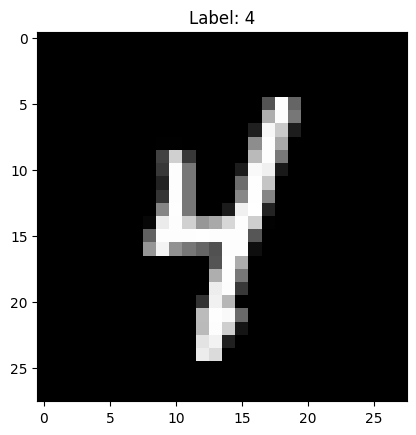

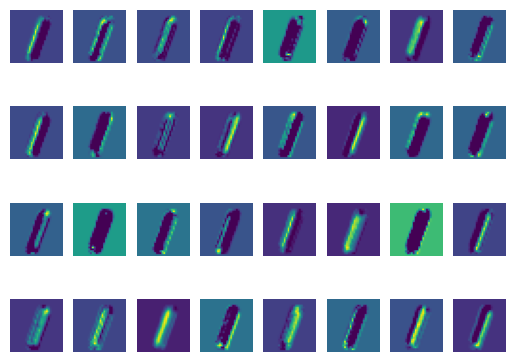

In [45]:
# Create an iterator for the dataset
ds_train_1_batched = ds_train.batch(1)
iterator = tf.compat.v1.data.make_one_shot_iterator(ds_train_1_batched)
image, label = iterator.get_next()


image_val, label_val = session.run([image, label])
# Reshape and display the image using matplotlib
plt.imshow(image_val[0, :, :, 0], cmap='gray')  # MNIST images are grayscale
plt.title(f"Label: {label_val[0]}")
plt.show()

flatened_image, label = flatten_image(image, label)
reshaped_image = tf.reshape(flatened_image, [1, 784])
image_val, label_val = session.run([reshaped_image, label])

feature_map = session.run([conv1], feed_dict={X_: image_val})[0]


for i in range(32):
  feature = feature_map[:,:,:,i].reshape([28, 28])
  plt.subplot(4,8, i + 1)
  plt.imshow(feature)
  plt.axis('off')
plt.show()

<h1> Capsule Network</h1>

In [47]:
def squash(sj):
 sj_norm = tf.reduce_sum(tf.square(sj), -2, keep_dims=True)
 scalar_factor = sj_norm / (1 + sj_norm) / tf.sqrt(sj_norm + epsilon)
 vj = scalar_factor * sj 
 return vj

In [ ]:
def dynamic_routing(ui, bij, num_routing=10):
  wij = tf.get_variable('Weight', shape=(1, 1152, 160, 8, 1), dtype=tf.float32,
                        initializer=tf.random_normal_initializer(0.01))
  biases = tf.get_variable('bias', shape=(1, 1, 10, 16, 1))
  ui = tf.tile(ui, [1, 1, 160, 1, 1])
  u_hat = tf.reduce_sum(wij * ui, axis=3, keep_dims=True)
  u_hat = tf.reshape(u_hat, shape=[-1, 1152, 10, 16, 1])
  u_hat_stopped = tf.stop_gradient(u_hat, name='stop_gradient')

  for r in range(num_routing):
    with tf.variable_scope('iter_' + str(r)):
      #step 1
      cij = tf.nn.softmax(bij, dim=2)
      #step 2
      if r == num_routing - 1:
        sj = tf.multiply(cij, u_hat)
        sj = tf.reduce_sum(sj, axis=1, keep_dims=True) + biases
        vj = squash(sj)
      elif r < num_routing - 1:
        sj = tf.multiply(cij, u_hat_stopped)
        sj = tf.reduce_sum(sj, axis=1, keep_dims=True) + biases
        vj = squash(sj)
        vj_tiled = tf.tile(vj, [1, 1152, 1, 1, 1])
        coupling_coeff = tf.reduce_sum(u_hat_stopped * vj_tiled, axis=3,
        keep_dims=True)
        #step 3
        bij += coupling_coeff
  return vj